In [12]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [13]:
%config IPCompleter.greedy=True

In [14]:
df = pd.read_csv('data/mitbih_train.csv', header=None)
df2 = pd.read_csv('data/mitbih_test.csv', header=None)
df = pd.concat([df, df2], axis=0)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB


In [15]:
M = df.values
X = M[:,:-1]
y = M[:,-1]
print(X.shape)
print(y.shape)

(109446, 187)
(109446,)


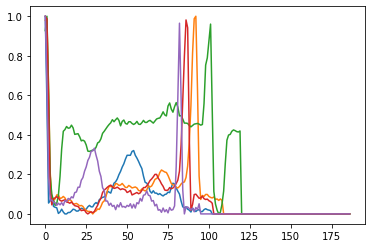

In [16]:
plt.plot(X[np.random.randint(0,100,5)].transpose())

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Model

In [18]:
from tensorflow.keras.layers import Input, Conv1D, MaxPool1D, Activation, Add, Dense
from tensorflow.keras.models import Model

In [19]:
input_shape = (187, 1)

I = Input(input_shape)
C = Conv1D(filters=32, kernel_size=5)(I)

C11 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(C)
C12 = Conv1D(filters=32, kernel_size=5, padding='same')(C11)
A11 = Add()([C, C12])
R11 = Activation(activation='relu')(A11)
M11 = MaxPool1D(pool_size=5, strides=2)(R11)

C21 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(M11)
C22 = Conv1D(filters=32, kernel_size=5, padding='same')(C21)
A21 = Add()([M11, C22])
R21 = Activation(activation='relu')(A21)
M21 = MaxPool1D(pool_size=5, strides=2)(R21)

C31 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(M21)
C32 = Conv1D(filters=32, kernel_size=5, padding='same')(C31)
A31 = Add()([M21, C32])
R31 = Activation(activation='relu')(A31)
M31 = MaxPool1D(pool_size=5, strides=2)(R31)

C41 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(M31)
C42 = Conv1D(filters=32, kernel_size=5, padding='same')(C41)
A41 = Add()([M31, C42])
R41 = Activation(activation='relu')(A41)
M41 = MaxPool1D(pool_size=5, strides=2)(R41)

C51 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(M41)
C52 = Conv1D(filters=32, kernel_size=5, padding='same')(C51)
A51 = Add()([M41, C52])
R51 = Activation(activation='relu')(A51)
M51 = MaxPool1D(pool_size=5, strides=2)(R51)

D1 = Dense(32)(M51)
R1 = Activation(activation='relu')(D1)
D2 = Dense(32)(R1)

O = Activation(activation='softmax')(D2)

model = Model(inputs=I, outputs=O)